In [3]:
import sys
import os
sys.path.append('../CGH_Toolbox/')
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
import numpy as np
import nglview as nv
import MDAnalysis as mda
import pyvibdmc as pv
import utilities as uts
import gaussian_tools as gt
import glob
import pandas as pd
import pickle
from scipy import interpolate
import dvr, utilities, dvr_arrays
from McUtils import Data as McData

# Load scans

In [2]:
clhocl_fchks = ['clhocl/clhocl_0_sp.fchk',
                'clhocl/clhocl_5_sp.fchk',
                'clhocl/clhocl_10_sp.fchk',
                'clhocl/clhocl_15_sp.fchk',
                'clhocl/clhocl_20_sp.fchk',
                'clhocl/clhocl_25_sp.fchk',
                'clhocl/clhocl_30_sp.fchk',
                'clhocl/clhocl_35_sp.fchk',
                'clhocl/clhocl_40_sp.fchk',
                'clhocl/clhocl_45_sp.fchk',
                'clhocl/clhocl_50_sp.fchk']

clhocl = gt.FchkInterpreter(fchks = clhocl_fchks,
                           cubes=True)

brhocl_fchks = ['brhocl/brhocl_0_sp.fchk',
                'brhocl/brhocl_5_sp.fchk',
                'brhocl/brhocl_10_sp.fchk',
                'brhocl/brhocl_15_sp.fchk',
                'brhocl/brhocl_20_sp.fchk',
                'brhocl/brhocl_25_sp.fchk',
                'brhocl/brhocl_30_sp.fchk',
                'brhocl/brhocl_35_sp.fchk',
                'brhocl/brhocl_40_sp.fchk',
                'brhocl/brhocl_45_sp.fchk',
                'brhocl/brhocl_50_sp.fchk']

brhocl = gt.FchkInterpreter(fchks = brhocl_fchks,
                           cubes=True)

ihocl_fchks = ['ihocl/ihocl_0_sp.fchk',
                'ihocl/ihocl_5_sp.fchk',
                'ihocl/ihocl_10_sp.fchk',
                'ihocl/ihocl_15_sp.fchk',
                'ihocl/ihocl_20_sp.fchk',
                'ihocl/ihocl_25_sp.fchk',
                'ihocl/ihocl_30_sp.fchk',
                'ihocl/ihocl_35_sp.fchk',
                'ihocl/ihocl_40_sp.fchk',
                'ihocl/ihocl_45_sp.fchk',
                'ihocl/ihocl_50_sp.fchk']

ihocl = gt.FchkInterpreter(fchks = ihocl_fchks,
                           cubes=True)

brhocl_pp_fchks = ['brhocl_pp/brhocl_pp_0_sp.fchk',
                'brhocl_pp/brhocl_pp_5_sp.fchk',
                'brhocl_pp/brhocl_pp_10_sp.fchk',
                'brhocl_pp/brhocl_pp_15_sp.fchk',
                'brhocl_pp/brhocl_pp_20_sp.fchk',
                'brhocl_pp/brhocl_pp_25_sp.fchk',
                'brhocl_pp/brhocl_pp_30_sp.fchk',
                'brhocl_pp/brhocl_pp_35_sp.fchk',
                'brhocl_pp/brhocl_pp_40_sp.fchk',
                'brhocl_pp/brhocl_pp_45_sp.fchk',
                'brhocl_pp/brhocl_pp_50_sp.fchk']

brhocl_pp = gt.FchkInterpreter(fchks = brhocl_pp_fchks,
                           cubes=True)

clhocl/clhocl_0_sp.fchk
DXDYDZO 0.2459302795698921 0.24635542499999996 0.246945552238806 0.014961507074184133
clhocl/clhocl_5_sp.fchk
DXDYDZO 0.2459302795698921 0.24635542499999996 0.246945552238806 0.014961507074184133
clhocl/clhocl_10_sp.fchk
DXDYDZO 0.2459302795698921 0.24635542499999996 0.246945552238806 0.014961507074184133
clhocl/clhocl_15_sp.fchk
DXDYDZO 0.2459302795698921 0.24635542499999996 0.246945552238806 0.014961507074184133
clhocl/clhocl_20_sp.fchk
DXDYDZO 0.2459302795698921 0.24635542499999996 0.246945552238806 0.014961507074184133
clhocl/clhocl_25_sp.fchk
DXDYDZO 0.2459302795698921 0.24635542499999996 0.246945552238806 0.014961507074184133
clhocl/clhocl_30_sp.fchk
DXDYDZO 0.2459302795698921 0.24635542499999996 0.246945552238806 0.014961507074184133
clhocl/clhocl_35_sp.fchk
DXDYDZO 0.2459302795698921 0.24635542499999996 0.246945552238806 0.014961507074184133
clhocl/clhocl_40_sp.fchk
DXDYDZO 0.2459302795698921 0.24635542499999996 0.246945552238806 0.014961507074184133
clh

# Plot Energies on harmonic potential

omega and reduced mass came from the frequency calculation

In [3]:
def v(x, omega, m): return 0.5*m*omega**2*x**2

def harmStates(nRange, omega):
    n = np.arange(0, nRange+1, 1)
    return (0.5 + n) *omega

def energy_on_harm_approx(energy_x,
                          energy_array,
                          harm_grid,
                          omega,
                          red_mass,
                          max_state,
                          **kwargs):
    """
    energy_x in degrees
    energy_array in Hartree
    harm_grid in degrees
    """
    minE = energy_array.min()
    energy_array = energy_array - minE
 
    fig = plt.figure()
    ax = plt.axes()
    ax.scatter(energy_x, 
               uts.Constants.convert(energy_array, 'wavenumbers', to_AU=False))
    ax.plot(harm_grid,
            uts.Constants.convert(v(np.deg2rad(harm_grid), omega, red_mass), 'wavenumbers', to_AU=False),
            color='k')
    states = uts.Constants.convert(harmStates(nRange=max_state, omega=omega), 'wavenumbers', to_AU=False)
    evenly_spaced_interval = np.linspace(0,0.9, max_state+1)
    colors = [cm.viridis(x) for x in evenly_spaced_interval]
    for i in range(len(states)):
        ax.axhline(y=states[i], color=colors[i], label=r"$\nu_{%s}$" %i)
    ax.legend()
    ax.set_ylabel("E (cm-1)")
    ax.set_xlabel("oop")
    
    
    
    
    

In [4]:
red_AMU = 1.0339

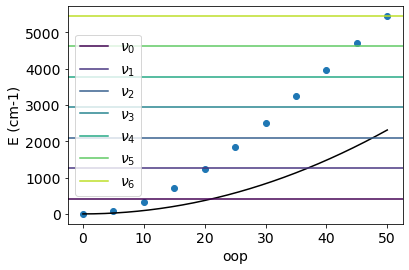

In [5]:
energy_on_harm_approx(energy_x=np.arange(0,55,5),
                      energy_array=clhocl.MP2Energy,
                      harm_grid= np.linspace(0,50,1001),
                      omega=uts.Constants.convert(841, 'wavenumbers', to_AU=True),
                      red_mass = uts.Constants.convert(red_AMU, 'amu', to_AU=True),
                      max_state=6)

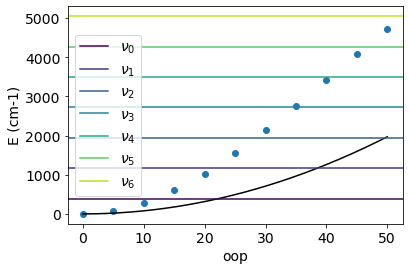

In [6]:
energy_on_harm_approx(energy_x=np.arange(0,55,5),
                      energy_array=brhocl.MP2Energy,
                      harm_grid= np.linspace(0,50,1001),
                      omega=uts.Constants.convert(776.09, 'wavenumbers', to_AU=True),
                      red_mass = uts.Constants.convert(1.0335, 'amu', to_AU=True),
                      max_state=6)

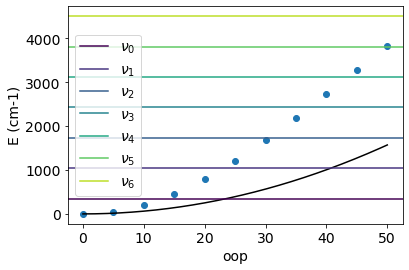

In [7]:
energy_on_harm_approx(energy_x=np.arange(0,55,5),
                      energy_array=ihocl.MP2Energy,
                      harm_grid= np.linspace(0,50,1001),
                      omega=uts.Constants.convert(693.03, 'wavenumbers', to_AU=True),
                      red_mass = uts.Constants.convert(1.0346, 'amu', to_AU=True),
                      max_state=6)

# Next Steps

- I need to run the same analysis for clhocl, brhocl, IHOCl, and X-HOD scans
- I should tighten the oop range and grid spacing because I am sampling up to like v=10

# Cl-HOCl

In [8]:
clhocl.mullikens[0]

array([-0.4999764 , -0.82952   ,  0.03757603,  0.29192036])

In [9]:
%matplotlib widget
fig, axs = plt.subplots(2,2)
oop = np.arange(0,55,5)

axs[0,0].scatter(oop, clhocl.mullikens[:,0], label="O", color="red")
axs[0,0].legend()
axs[0,1].scatter(oop, clhocl.mullikens[:,1], label="Cl colinear with O and H", color='green')
axs[0,1].legend(loc="best")
axs[1,0].scatter(oop, clhocl.mullikens[:,2], label="Cl", color='green')
axs[1,0].legend()
axs[1,1].scatter(oop, clhocl.mullikens[:,3], label="H", color='gray')
axs[1,1].legend()
#plt.subplots_adjust(wspace=0, hspace=0)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Mulliken Plot

In [12]:
%matplotlib widget
figs, axs = plt.subplots(4, 3, sharex=True)


oop = np.arange(0,55,5)
axs[0,0].scatter(oop, clhocl.mullikens[:,0], label="O", color="red")
axs[1,0].scatter(oop, clhocl.mullikens[:,1], label="Cl ion", color='green')
axs[2,0].scatter(oop, clhocl.mullikens[:,2], label="Cl", color='green')
axs[3,0].scatter(oop, clhocl.mullikens[:,3], label="H", color='gray')

axs[0,1].scatter(oop, brhocl.mullikens[:,0], label="O", color="red")
axs[1,1].scatter(oop, brhocl.mullikens[:,1], label="Br ion", color='maroon')
axs[2,1].scatter(oop, brhocl.mullikens[:,2], label="Cl", color='green')
axs[3,1].scatter(oop, brhocl.mullikens[:,3], label="H", color='gray')

axs[0,2].scatter(oop, ihocl.mullikens[:,0], label="O", color="red")
axs[1,2].scatter(oop, ihocl.mullikens[:,1], label="I ion", color='purple')
axs[2,2].scatter(oop, ihocl.mullikens[:,2], label="Cl", color='green')
axs[3,2].scatter(oop, ihocl.mullikens[:,3], label="H", color='gray')

axs[0,0].get_shared_y_axes().join(axs[0,0], axs[0,1], axs[0,2])
axs[1,0].get_shared_y_axes().join(axs[1,0], axs[1,1], axs[1,2])
axs[2,0].get_shared_y_axes().join(axs[2,0], axs[2,1], axs[2,2])
axs[3,0].get_shared_y_axes().join(axs[3,0], axs[3,1], axs[3,2])

"""for a in axs:
    for b in a:
        b.legend()"""
        
axs[0,0].set_title("ClHOCl")
axs[0,1].set_title("BrHOCl")
axs[0,2].set_title("IHOCl")

axs[0,0].set_ylabel("O charge")
axs[1,0].set_ylabel("X charge")
axs[2,0].set_ylabel("Cl charge")
axs[3,0].set_ylabel("H charge")

fig.subplots_adjust(wspace = 0, hspace = 0)
#fig.set_size_inches(w=6,h=8.5)
        
plt.tight_layout()

plt.savefig('Mulliken_charges1.pdf')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [13]:
%matplotlib widget
figs, axs = plt.subplots(4, 2, sharex=True)


oop = np.arange(0,55,5)
axs[0,0].scatter(oop, clhocl.mullikens[:,0], label="ClHOCl- O", color="green")
axs[1,0].scatter(oop, clhocl.mullikens[:,1], label="ClHOCl- Cl ion", color='green')
axs[2,0].scatter(oop, clhocl.mullikens[:,2], label="ClHOCl- Cl", color='green')
axs[3,0].scatter(oop, clhocl.mullikens[:,3], label="ClHOCl- H", color='green')

axs[0,0].scatter(oop, brhocl.mullikens[:,0], label="BrHOCl- O", color="maroon")
axs[1,0].scatter(oop, brhocl.mullikens[:,1], label="BrHOCl- Br ion", color='maroon')
axs[2,0].scatter(oop, brhocl.mullikens[:,2], label="BrHOCl- Cl", color='maroon')
axs[3,0].scatter(oop, brhocl.mullikens[:,3], label="BrHOCl- H", color='maroon')

axs[0,0].scatter(oop, ihocl.mullikens[:,0], label="IHOCl- O", color="purple")
axs[1,0].scatter(oop, ihocl.mullikens[:,1], label="IHOCl- I ion", color='purple')
axs[2,0].scatter(oop, ihocl.mullikens[:,2], label="IHOCl- Cl", color='purple')
axs[3,0].scatter(oop, ihocl.mullikens[:,3], label="IHOCl- H", color='purple')

axs[0,1].scatter(oop, clhocl.mullikens[:,0], label="ClHOCl- O", color="green")
axs[1,1].scatter(oop, clhocl.mullikens[:,1], label="ClHOCl- Cl ion", color='green')
axs[2,1].scatter(oop, clhocl.mullikens[:,2], label="ClHOCl- Cl", color='green')
axs[3,1].scatter(oop, clhocl.mullikens[:,3], label="ClHOCl- H", color='green')

axs[0,1].scatter(oop, brhocl_pp.mullikens[:,0], label="BrHOCl- O", color="maroon")
axs[1,1].scatter(oop, brhocl_pp.mullikens[:,1], label="BrHOCl- Br ion", color='maroon')
axs[2,1].scatter(oop, brhocl_pp.mullikens[:,2], label="BrHOCl- Cl", color='maroon')
axs[3,1].scatter(oop, brhocl_pp.mullikens[:,3], label="BrHOCl- H", color='maroon')

axs[0,1].scatter(oop, ihocl.mullikens[:,0], label="IHOCl- O", color="purple")
axs[1,1].scatter(oop, ihocl.mullikens[:,1], label="IHOCl- I ion", color='purple')
axs[2,1].scatter(oop, ihocl.mullikens[:,2], label="IHOCl- Cl", color='purple')
axs[3,1].scatter(oop, ihocl.mullikens[:,3], label="IHOCl- H", color='purple')

"""axs[0].get_shared_y_axes().join(axs[0,0], axs[0,1], axs[0,2])
axs[1].get_shared_y_axes().join(axs[1,0], axs[1,1], axs[1,2])
axs[2].get_shared_y_axes().join(axs[2,0], axs[2,1], axs[2,2])
axs[3].get_shared_y_axes().join(axs[3,0], axs[3,1], axs[3,2])"""

for a in axs:
    for b in a:
        b.legend(loc='best')
        
"""axs[0,0].set_title("ClHOCl")
axs[0,1].set_title("BrHOCl")
axs[0,2].set_title("IHOCl")"""

axs[0,0].set_ylabel("O charge")
axs[1,0].set_ylabel("X charge")
axs[2,0].set_ylabel("Cl charge")
axs[3,0].set_ylabel("H charge")

axs[0,0].set_title("tz")
axs[0,1].set_title("pp")



fig.subplots_adjust(wspace = 0, hspace = 0)
#fig.set_size_inches(w=6,h=8.5)
        
plt.tight_layout()

plt.savefig('Mulliken_charges2.pdf')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [23]:
# make a pandas table of total changes in charges for each atom

In [24]:
clhocl_mull_data = [['O'], ['Cl ion'], ['Cl'], ['H']]
for i in range(len(clhocl_mull_data)):
    for d in clhocl.mullikens[:,i]:
        clhocl_mull_data[i].append(d)
    clhocl_mull_data[i].append(clhocl.mullikens[:,i][-1]-clhocl.mullikens[:,i][0])

In [25]:
brhocl_mull_data = [['O'], ['Br ion'], ['Cl'], ['H']]
for i in range(len(brhocl_mull_data)):
    for d in brhocl.mullikens[:,i]:
        brhocl_mull_data[i].append(d)
    brhocl_mull_data[i].append(brhocl.mullikens[:,i][-1]-brhocl.mullikens[:,i][0])

In [26]:
ihocl_mull_data = [['O'], ['I ion'], ['Cl'], ['H']]
for i in range(len(ihocl_mull_data)):
    for d in ihocl.mullikens[:,i]:
        ihocl_mull_data[i].append(d)
    ihocl_mull_data[i].append(ihocl.mullikens[:,i][-1]-ihocl.mullikens[:,i][0])

In [27]:
clhocl_mull_df = pd.DataFrame(clhocl_mull_data, columns = ['Atom', '0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', 'total change'])
brhocl_mull_df = pd.DataFrame(brhocl_mull_data, columns = ['Atom', '0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', 'total change'])
ihocl_mull_df = pd.DataFrame(ihocl_mull_data, columns = ['Atom', '0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', 'total change'])

## ClHOCl mulliken charges

In [28]:
clhocl_mull_df

,Atom,0,5,10,15,20,25,30,35,40,45,50,total change
0,O,-0.499976,-0.498003,-0.490673,-0.478233,-0.461254,-0.442305,-0.423297,-0.406525,-0.392569,-0.381906,-0.373439,0.126538
1,Cl ion,-0.829520,-0.831432,-0.837965,-0.847528,-0.859269,-0.871933,-0.885221,-0.898496,-0.911555,-0.923941,-0.935535,-0.106015
2,Cl,0.037576,0.038300,0.040704,0.044239,0.048578,0.053256,0.058061,0.062630,0.066686,0.069905,0.072134,0.034558
3,H,0.291920,0.291135,0.287934,0.281522,0.271945,0.260982,0.250457,0.242391,0.237438,0.235941,0.236840,-0.055080


## BrHOCl mulliken charges

In [29]:
brhocl_mull_df

,Atom,0,5,10,15,20,25,30,35,40,45,50,total change
0,O,-0.494229,-0.491730,-0.483618,-0.470621,-0.453988,-0.435930,-0.418649,-0.403687,-0.391613,-0.382135,-0.374472,0.119756
1,Br ion,-0.845958,-0.847476,-0.852440,-0.859920,-0.869230,-0.879559,-0.890387,-0.901486,-0.912762,-0.924067,-0.935134,-0.089176
2,Cl,0.048102,0.048551,0.050055,0.052393,0.055455,0.059037,0.062896,0.066748,0.070289,0.073237,0.075384,0.027282
3,H,0.292085,0.290656,0.286003,0.278148,0.267763,0.256452,0.246140,0.238425,0.234086,0.232966,0.234222,-0.057863


## IHOCl mulliken charges

In [30]:
ihocl_mull_df

,Atom,0,5,10,15,20,25,30,35,40,45,50,total change
0,O,-0.488498,-0.486030,-0.478492,-0.466675,-0.451710,-0.435256,-0.419066,-0.404499,-0.392232,-0.382468,-0.374111,0.114387
1,I ion,-0.835791,-0.836559,-0.839716,-0.845764,-0.854731,-0.865886,-0.878320,-0.891311,-0.904381,-0.917164,-0.929430,-0.093640
2,Cl,0.054022,0.054554,0.056128,0.058445,0.061316,0.064565,0.068007,0.071425,0.074578,0.077236,0.079258,0.025236
3,H,0.270267,0.268034,0.262080,0.253994,0.245126,0.236577,0.229379,0.224385,0.222036,0.222396,0.224284,-0.045983


## Combined Mulliken Charges

In [31]:
mull_data = [['O'], ['X'], ['Cl'], ['H']]
for i in range(len(mull_data)):
    mull_data[i].append(clhocl.mullikens[:,i][-1]-clhocl.mullikens[:,i][0])
    mull_data[i].append(brhocl.mullikens[:,i][-1]-brhocl.mullikens[:,i][0])
    mull_data[i].append(ihocl.mullikens[:,i][-1]-ihocl.mullikens[:,i][0])

mull_df = pd.DataFrame(mull_data, columns = ['Atom', 'change ClHOCl', 'change BrHOCl', 'change IHOCl'])

In [32]:
mull_df

,Atom,change ClHOCl,change BrHOCl,change IHOCl
0,O,0.126538,0.119756,0.114387
1,X,-0.106015,-0.089176,-0.093640
2,Cl,0.034558,0.027282,0.025236
3,H,-0.055080,-0.057863,-0.045983


# Natural Charges:

In [33]:
with open('clhocl/natural_charges.txt', 'r') as f:
    lines = f.readlines()
    split = []
    for line in lines:
        split.append(line.split())

In [5]:
def pull_charges(file, rearrange=False):
    split = []
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            split.append(line.split())
        
    d = {}

    for line in split:
        #print(line)
        if len(line) < 2:
            continue
        if line[1] in ['O', 'Br', 'Cl', 'I', 'H']:
            head = line[0].split('_')
            for h in head:
                if h.isdigit():
                    key = h + "-" + line[1]
            #key = line[0].split('_')[1] + "-" + line[1]
            #print(key)
            if key in d:
                key = key + "_1"
            d[key] = line[3]

    n_d = {}
    for key in d:
        s = key.split('-')
        if s[0] in n_d:
            n_d[s[0]].append(d[key])
        else:
            n_d[s[0]] = [d[key]]
    for key in n_d:
        n_d[key] = np.array(n_d[key])
    #print(n_d)
    l = []
    keys = list(n_d.keys())
    if rearrange:
        keys.insert(1, keys.pop(-1)) 
    for k in keys:
        l.append(n_d[k])
    return np.asarray(l, dtype=float)
        
    
        

In [31]:
clhocl_oop_nbo = pull_charges('oop_s_rOH_opt/clhocl/natural_charges.txt', rearrange=True)
ihocl_oop_nbo = pull_charges('oop_s_rOH_opt/ihocl/natural_charges.txt', rearrange=True)
brhocl_oop_nbo = pull_charges('oop_s_rOH_opt/brhocl/natural_charges.txt', rearrange=True)
brhocl_oop_pp_nbo = pull_charges('oop_s_rOH_opt/brhocl_pp/natural_charges.txt', rearrange=True)
clhod_oop_nbo = pull_charges('oop_s_rOH_opt/clhod/natural_charges.txt')
brhod_oop_nbo = pull_charges('oop_s_rOH_opt/brhod/natural_charges.txt')
ihod_oop_nbo = pull_charges('oop_s_rOH_opt/ihod/natural_charges.txt')



In [15]:
clhocl_rOH_nbo[:,1]

array([0.16759, 0.16612, 0.16398, 0.16113, 0.15751, 0.15308, 0.14785,
       0.14188, 0.13526, 0.12812, 0.12058, 0.11274, 0.10466, 0.09649,
       0.08816, 0.07988])

In [22]:
%matplotlib widget
figs, axs = plt.subplots(4, 3, sharex=True)


oop = np.arange(0,55,5)
axs[0,0].scatter(oop, clhocl.mullikens[:,0], label="X=O", color='green', marker='.')
axs[1,0].scatter(oop, clhocl.mullikens[:,1], label="X=Cl", color='green', marker='.')
axs[2,0].scatter(oop, clhocl.mullikens[:,2], label="X=Cl", color='green', marker='.')
axs[3,0].scatter(oop, clhocl.mullikens[:,3], label="X=H", color='green', marker='.')

axs[0,0].scatter(oop, brhocl.mullikens[:,0], label="X=O", color='maroon', marker='v')
axs[1,0].scatter(oop, brhocl.mullikens[:,1], label="X=Br", color='maroon', marker='v')
axs[2,0].scatter(oop, brhocl.mullikens[:,2], label="X=Cl", color='maroon', marker='v')
axs[3,0].scatter(oop, brhocl.mullikens[:,3], label="X=H", color='maroon', marker='v')

axs[0,0].scatter(oop, ihocl.mullikens[:,0], label="X=O", color='purple', marker='x')
axs[1,0].scatter(oop, ihocl.mullikens[:,1], label="X=I", color='purple', marker='x')
axs[2,0].scatter(oop, ihocl.mullikens[:,2], label="X=Cl", color='purple', marker='x')
axs[3,0].scatter(oop, ihocl.mullikens[:,3], label="X=H", color='purple', marker='x')

axs[0,1].scatter(oop, clhocl.mullikens[:,0], label="X=O", color='green', marker='.')
axs[1,1].scatter(oop, clhocl.mullikens[:,1], label="X=Cl", color='green', marker='.')
axs[2,1].scatter(oop, clhocl.mullikens[:,2], label="X=Cl", color='green', marker='.')
axs[3,1].scatter(oop, clhocl.mullikens[:,3], label="X=H", color='green', marker='.')

axs[0,1].scatter(oop, brhocl_pp.mullikens[:,0], label="X=O", color='maroon', marker='v')
axs[1,1].scatter(oop, brhocl_pp.mullikens[:,1], label="X=Br", color='maroon', marker='v')
axs[2,1].scatter(oop, brhocl_pp.mullikens[:,2], label="X=Cl", color='maroon', marker='v')
axs[3,1].scatter(oop, brhocl_pp.mullikens[:,3], label="X=H", color='maroon', marker='v')

axs[0,1].scatter(oop, ihocl.mullikens[:,0], label="X=O", color='purple', marker='x')
axs[1,1].scatter(oop, ihocl.mullikens[:,1], label="X=I", color='purple', marker='x')
axs[2,1].scatter(oop, ihocl.mullikens[:,2], label="X=Cl", color='purple', marker='x')
axs[3,1].scatter(oop, ihocl.mullikens[:,3], label="X=H", color='purple', marker='x')

axs[0,2].scatter(oop, clhocl_nbo[:,0], label="X=O", color='green', marker='.')
axs[1,2].scatter(oop, clhocl_nbo[:,1], label="X=Cl", color='green', marker='.')
axs[2,2].scatter(oop, clhocl_nbo[:,2], label="X=Cl", color='green', marker='.')
axs[3,2].scatter(oop, clhocl_nbo[:,3], label="X=H", color='green', marker='.')

axs[0,2].scatter(oop, brhocl_nbo[:,0], label="X=O", color='maroon', marker='v')
axs[1,2].scatter(oop, brhocl_nbo[:,1], label="X=Br", color='maroon', marker='v')
axs[2,2].scatter(oop, brhocl_nbo[:,2], label="X=Cl", color='maroon', marker='v')
axs[3,2].scatter(oop, brhocl_nbo[:,3], label="X=H", color='maroon', marker='v')

axs[0,2].scatter(oop, ihocl_nbo[:,0], label="X=O", color='purple', marker='x')
axs[1,2].scatter(oop, ihocl_nbo[:,1], label="X=I", color='purple', marker='x')
axs[2,2].scatter(oop, ihocl_nbo[:,2], label="X=Cl", color='purple', marker='x')
axs[3,2].scatter(oop, ihocl_nbo[:,3], label="X=H", color='purple', marker='x')

"""axs[0].get_shared_y_axes().join(axs[0,0], axs[0,1], axs[0,2])
axs[1].get_shared_y_axes().join(axs[1,0], axs[1,1], axs[1,2])
axs[2].get_shared_y_axes().join(axs[2,0], axs[2,1], axs[2,2])
axs[3].get_shared_y_axes().join(axs[3,0], axs[3,1], axs[3,2])"""

for a in axs:
    for b in a:
        b.legend(loc='best')
        
"""axs[0,0].set_title("ClHOCl")
axs[0,1].set_title("BrHOCl")
axs[0,2].set_title("IHOCl")"""

axs[0,0].set_ylabel("O charge")
axs[1,0].set_ylabel("X charge")
axs[2,0].set_ylabel("Cl charge")
axs[3,0].set_ylabel("H charge")

axs[0,0].set_title("Mulliken tz")
axs[0,1].set_title("Mulliken pp")
axs[0,2].set_title("NBO tz")



fig.subplots_adjust(wspace = 0, hspace = 0)
#fig.set_size_inches(w=6,h=8.5)
        
plt.tight_layout()

plt.savefig('Mulliken_charges.pdf')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'clhocl' is not defined

In [23]:
%matplotlib widget
fig, axs = plt.subplots(4, 3, sharex=True)


oop = np.arange(0,55,5)
axs[0,0].scatter(oop, clhocl_nbo[:,0], label="X=Cl", color='green', marker='.')
axs[1,0].scatter(oop, clhocl_nbo[:,1], label="X=Cl", color='green', marker='.')
axs[2,0].scatter(oop, clhocl_nbo[:,2], label="X=Cl", color='green', marker='.')
axs[3,0].scatter(oop, clhocl_nbo[:,3], label="X=Cl", color='green', marker='.')

axs[0,0].scatter(oop, brhocl_nbo[:,0], label="X=Br", color='maroon', marker='v')
axs[1,0].scatter(oop, brhocl_nbo[:,1], label="X=Br", color='maroon', marker='v')
axs[2,0].scatter(oop, brhocl_nbo[:,2], label="X=Br", color='maroon', marker='v')
axs[3,0].scatter(oop, brhocl_nbo[:,3], label="X=Br", color='maroon', marker='v')

axs[0,0].scatter(oop, ihocl_nbo[:,0], label="X=I", color='purple', marker='x')
axs[1,0].scatter(oop, ihocl_nbo[:,1], label="X=I", color='purple', marker='x')
axs[2,0].scatter(oop, ihocl_nbo[:,2], label="X=I", color='purple', marker='x')
axs[3,0].scatter(oop, ihocl_nbo[:,3], label="X=I", color='purple', marker='x')

axs[0,1].scatter(oop, clhocl_nbo[:,0], label="X=Cl", color='green', marker='.')
axs[1,1].scatter(oop, clhocl_nbo[:,1], label="X=Cl", color='green', marker='.')
axs[2,1].scatter(oop, clhocl_nbo[:,2], label="X=Cl", color='green', marker='.')
axs[3,1].scatter(oop, clhocl_nbo[:,3], label="X=Cl", color='green', marker='.')

axs[0,1].scatter(oop, brhocl_pp_nbo[:,0], label="X=Br", color='maroon', marker='v')
axs[1,1].scatter(oop, brhocl_pp_nbo[:,1], label="X=Br", color='maroon', marker='v')
axs[2,1].scatter(oop, brhocl_pp_nbo[:,2], label="X=Br", color='maroon', marker='v')
axs[3,1].scatter(oop, brhocl_pp_nbo[:,3], label="X=Br", color='maroon', marker='v')

axs[0,1].scatter(oop, ihocl_nbo[:,0], label="X=I", color='purple', marker='x')
axs[1,1].scatter(oop, ihocl_nbo[:,1], label="X=I", color='purple', marker='x')
axs[2,1].scatter(oop, ihocl_nbo[:,2], label="X=I", color='purple', marker='x')
axs[3,1].scatter(oop, ihocl_nbo[:,3], label="X=I", color='purple', marker='x')

axs[0,2].scatter(oop, brhocl_pp_nbo[:,0] - brhocl_nbo[:,0], label="X=Br", color='maroon', marker='v')
axs[1,2].scatter(oop, brhocl_pp_nbo[:,1] - brhocl_nbo[:,1], label="X=Br", color='maroon', marker='v')
axs[2,2].scatter(oop, brhocl_pp_nbo[:,2] - brhocl_nbo[:,2], label="X=Br", color='maroon', marker='v')
axs[3,2].scatter(oop, brhocl_pp_nbo[:,3] - brhocl_nbo[:,3], label="X=Br", color='maroon', marker='v')

"""axs[0].get_shared_y_axes().join(axs[0,0], axs[0,1], axs[0,2])
axs[1].get_shared_y_axes().join(axs[1,0], axs[1,1], axs[1,2])
axs[2].get_shared_y_axes().join(axs[2,0], axs[2,1], axs[2,2])
axs[3].get_shared_y_axes().join(axs[3,0], axs[3,1], axs[3,2])"""

for a in axs:
    for b in a:
        b.legend(loc='best')
        
"""axs[0,0].set_title("ClHOCl")
axs[0,1].set_title("BrHOCl")
axs[0,2].set_title("IHOCl")"""

for a in axs[0,:]:
    a.set_ylabel("O charge")
for a in axs[1,:]:
    a.set_ylabel("X charge")
for a in axs[2,:]:
    a.set_ylabel("Cl charge")
for a in axs[3,:]:
    a.set_ylabel("H charge")


axs[0,0].set_title("NBO tz")
axs[0,1].set_title("NBO pp")
axs[0,2].set_title("Br pp-tz")



fig.subplots_adjust(wspace = 0, hspace = 0)
fig.set_size_inches(w=10,h=10)
        
plt.tight_layout()

plt.savefig('NBO_charges.pdf')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'clhocl_nbo' is not defined

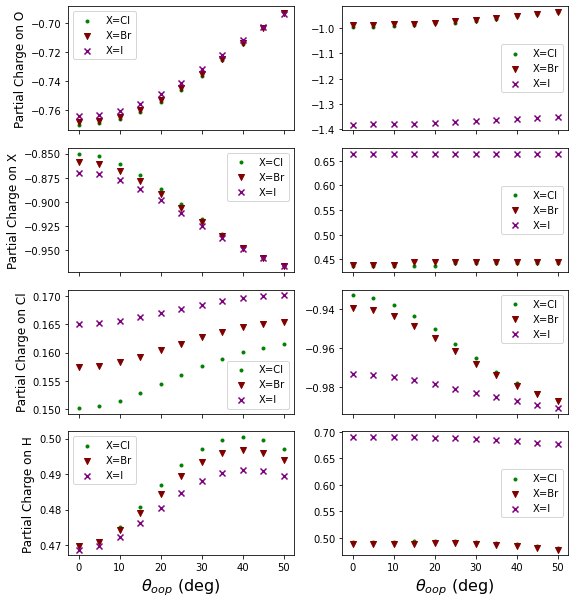

In [32]:
%matplotlib inline
fig, axs = plt.subplots(4, 2, sharex=True)


oop = np.arange(0,55,5)
for i in range(4): axs[i,0].scatter(oop, clhocl_oop_nbo[:,i], label="X=Cl", color='green', marker='.')
for i in range(4): axs[i,0].scatter(oop, brhocl_oop_nbo[:,i], label="X=Br", color='maroon', marker='v')
for i in range(4): axs[i,0].scatter(oop, ihocl_oop_nbo[:,i], label="X=I", color='purple', marker='x')
for i in range(4): axs[i,1].scatter(oop, clhod_oop_nbo[:,i], label="X=Cl", color='green', marker='.')
for i in range(4): axs[i,1].scatter(oop, brhod_oop_nbo[:,i], label="X=Br", color='maroon', marker='v')
for i in range(4): axs[i,1].scatter(oop, ihod_oop_nbo[:,i], label="X=I", color='purple', marker='x')

for a in axs:
    for b in a:
        b.legend(loc='best')
        
#axs[0].set_title("NBO tz")
axs[0,0].set_ylabel("Partial Charge on O", fontsize=12)
axs[1,0].set_ylabel("Partial Charge on X", fontsize=12)
axs[2,0].set_ylabel("Partial Charge on Cl", fontsize=12)
axs[3,0].set_ylabel("Partial Charge on H", fontsize=12)

axs[3,0].set_xlabel(r'$\theta_{oop}$ (deg)', fontsize=16)
axs[3,1].set_xlabel(r'$\theta_{oop}$ (deg)', fontsize=16)


fig.subplots_adjust(wspace = 0, hspace = 0)
fig.set_size_inches(w=8,h=8.5)
        
plt.tight_layout()

plt.savefig('natural_charges.pdf')


In [19]:
clhocl_rOH_nbo[:,0].shape

(16,)

In [21]:
np.arange(0.75,1.55,5)

array([0.75])

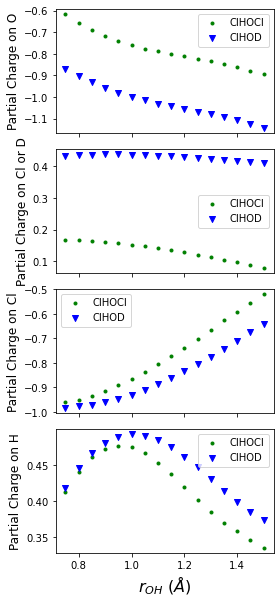

In [35]:
%matplotlib inline
fig, axs = plt.subplots(4, 1, sharex=True)


oop = np.arange(0.75,1.55,0.05)
axs[0].scatter(oop, clhocl_rOH_nbo[:,0], label="ClHOCl", color='green', marker='.')
axs[1].scatter(oop, clhocl_rOH_nbo[:,1], label="ClHOCl", color='green', marker='.')
axs[2].scatter(oop, clhocl_rOH_nbo[:,2], label="ClHOCl", color='green', marker='.')
axs[3].scatter(oop, clhocl_rOH_nbo[:,3], label="ClHOCl", color='green', marker='.')

axs[0].scatter(oop, clhod_rOH_nbo[:,0], label="ClHOD", color='blue', marker='v')
axs[1].scatter(oop, clhod_rOH_nbo[:,1], label="ClHOD", color='blue', marker='v')
axs[2].scatter(oop, clhod_rOH_nbo[:,2], label="ClHOD", color='blue', marker='v')
axs[3].scatter(oop, clhod_rOH_nbo[:,3], label="ClHOD", color='blue', marker='v')


for a in axs:
    a.legend(loc='best')
        
#axs[0].set_title("NBO tz")
axs[0].set_ylabel("Partial Charge on O", fontsize=12)
axs[1].set_ylabel("Partial Charge on Cl or D", fontsize=12)
axs[2].set_ylabel("Partial Charge on Cl", fontsize=12)
axs[3].set_ylabel("Partial Charge on H", fontsize=12)

axs[3].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)


fig.subplots_adjust(wspace = 0, hspace = 0)
fig.set_size_inches(w=4,h=8.5)
        
plt.tight_layout()

plt.savefig('natural_charges_clhocl_v_clhod.pdf')


jcpb paper, can you undertsand intenstity by looking at how PT expansion plays in
if I excite a vibration, how does the coupling change, and how is that shown in the spectroscopy

we have with marks code a way to extract insights

marks v standard...
interesting questions

PT-
    - OO distance, structural changes, excitation in dofs
    - trace back to terms...where is it coming from?
    - how can you think about the mechanisms
    - chem review markland 25-29 nuclear quantum effects of water in aqueous systems, theory and current challenges
    
science cs water 20 "pg 265 2019"

reading on NBO

# Whats the plan?

- oop scan for XHOD
- r_OH for planar XHOCl and XHOD
    - scan up to 5000-7500 cm, 0.75-1.35 with 0.05 steps
- oop scans with rigid rOH
    - start with HOCl by itself, optimize, then add in x and optimize rOH (rOX?) with fixed HOCl parameters
    - then run a scan changing oop with the optimized rOH

# Planar Geometry: scanning along rOH

In [10]:
clhocl_rOH_nbo = pull_charges('rOH_s_oop_0/clhocl/natural_charges.txt')
clhod_rOH_nbo = pull_charges('rOH_s_oop_0/clhod/natural_charges.txt')
brhocl_rOH_nbo = pull_charges('rOH_s_oop_0/brhocl/natural_charges.txt')
brhocl_pp_rOH_nbo = pull_charges('rOH_s_oop_0/brhocl_pp/natural_charges.txt')
brhod_rOH_nbo = pull_charges('rOH_s_oop_0/brhod/natural_charges.txt')
brhod_pp_rOH_nbo = pull_charges('rOH_s_oop_0/brhod_pp/natural_charges.txt')
ihocl_rOH_nbo = pull_charges('rOH_s_oop_0/ihocl/natural_charges.txt')
ihod_rOH_nbo = pull_charges('rOH_s_oop_0/ihod/natural_charges.txt')

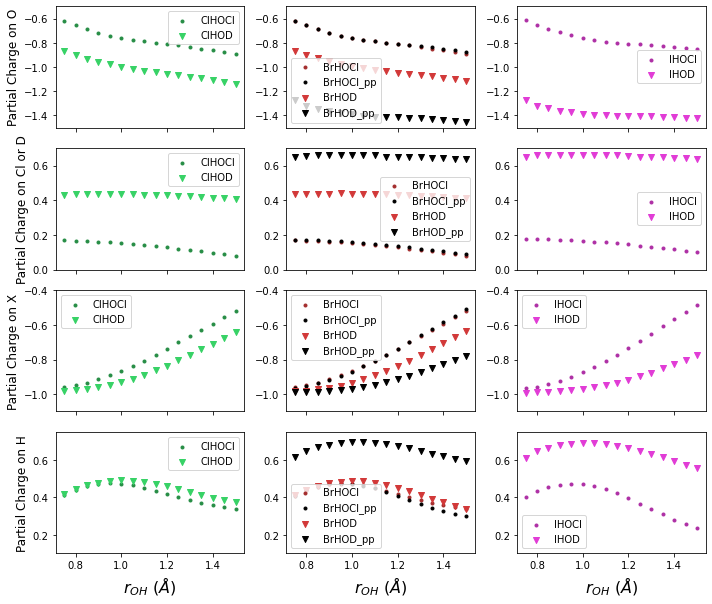

In [16]:
%matplotlib inline
fig, axs = plt.subplots(4, 3, sharex=True)

oop = np.arange(0.75,1.55,0.05)
for i in range(4):axs[i,0].scatter(oop, clhocl_rOH_nbo[:,i], label="ClHOCl", color='#268D45', marker='.')
for i in range(4):axs[i,0].scatter(oop, clhod_rOH_nbo[:,i], label="ClHOD", color='#37D266', marker='v')
for i in range(4):axs[i,1].scatter(oop, brhocl_rOH_nbo[:,i], label="BrHOCl", color='#A42D2D', marker='.')
for i in range(4):axs[i,1].scatter(oop, brhocl_pp_rOH_nbo[:,i],label="BrHOCl_pp", color='black', marker='.')
for i in range(4):axs[i,1].scatter(oop, brhod_rOH_nbo[:,i], label="BrHOD", color='#D23939', marker='v')
for i in range(4):axs[i,1].scatter(oop, brhod_pp_rOH_nbo[:,i], label="BrHOD_pp", color='black', marker='v')
for i in range(4):axs[i,2].scatter(oop, ihocl_rOH_nbo[:,i], label="IHOCl", color='#AE2FA5', marker='.')
for i in range(4):axs[i,2].scatter(oop, ihod_rOH_nbo[:,i], label="IHOD", color='#E13CD6', marker='v')

for ax in axs[0,:]:ax.set_ylim(-1.5, -0.5)  
for ax in axs[1,:]:ax.set_ylim(0, 0.7)
for ax in axs[2,:]:ax.set_ylim(-1.1, -0.4)
for ax in axs[3,:]:ax.set_ylim(0.1, 0.75)
for a in axs:
    for b in a:
        b.legend(loc='best')
        
axs[0,0].set_ylabel("Partial Charge on O", fontsize=12)
axs[1,0].set_ylabel("Partial Charge on Cl or D", fontsize=12)
axs[2,0].set_ylabel("Partial Charge on X", fontsize=12)
axs[3,0].set_ylabel("Partial Charge on H", fontsize=12)

axs[3,0].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)
axs[3,1].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)
axs[3,2].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)


fig.subplots_adjust(wspace = 0, hspace = 0)
fig.set_size_inches(w=10,h=8.5)
plt.tight_layout()
plt.savefig('natural_charges_xhocl_v_xhod.pdf')

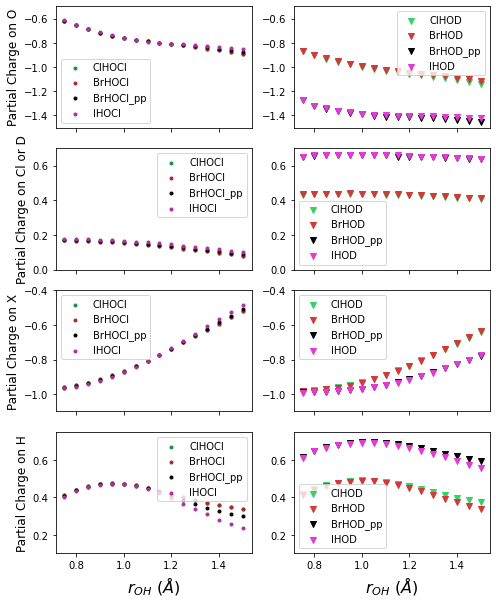

In [18]:
%matplotlib inline
fig, axs = plt.subplots(4, 2, sharex=True)

oop = np.arange(0.75,1.55,0.05)
for i in range(4): axs[i,0].scatter(oop, clhocl_rOH_nbo[:,i], label="ClHOCl", color='#268D45', marker='.')
for i in range(4): axs[i,1].scatter(oop, clhod_rOH_nbo[:,i], label="ClHOD", color='#37D266', marker='v')
for i in range(4): axs[i,0].scatter(oop, brhocl_rOH_nbo[:,i], label="BrHOCl", color='#A42D2D', marker='.')
for i in range(4): axs[i,0].scatter(oop, brhocl_pp_rOH_nbo[:,i], label="BrHOCl_pp", color='black', marker='.')
for i in range(4): axs[i,1].scatter(oop, brhod_rOH_nbo[:,i], label="BrHOD", color='#D23939', marker='v')
for i in range(4): axs[i,1].scatter(oop, brhod_pp_rOH_nbo[:,i], label="BrHOD_pp", color='black', marker='v')
for i in range(4): axs[i,0].scatter(oop, ihocl_rOH_nbo[:,i], label="IHOCl", color='#AE2FA5', marker='.')
for i in range(4): axs[i,1].scatter(oop, ihod_rOH_nbo[:,i], label="IHOD", color='#E13CD6', marker='v')

for ax in axs[0,:]:ax.set_ylim(-1.5, -0.5) 
for ax in axs[1,:]:ax.set_ylim(0, 0.7)
for ax in axs[2,:]:ax.set_ylim(-1.1, -0.4)
for ax in axs[3,:]:ax.set_ylim(0.1, 0.75)
for a in axs:
    for b in a:
        b.legend(loc='best')
        
axs[0,0].set_ylabel("Partial Charge on O", fontsize=12)
axs[1,0].set_ylabel("Partial Charge on Cl or D", fontsize=12)
axs[2,0].set_ylabel("Partial Charge on X", fontsize=12)
axs[3,0].set_ylabel("Partial Charge on H", fontsize=12)
axs[3,0].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)
axs[3,1].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)

fig.subplots_adjust(wspace = 0, hspace = 0)
fig.set_size_inches(w=7,h=8.5)
plt.tight_layout()
plt.savefig('natural_charges_xhocl_v_xhod_version2.pdf')


- Oxygen
    - all about the same for XHOD
    - much more negative in IHOCl than in ClHOCl and BrHOCl (I less electronegative?)

- Cl/D
    - D is much more positive on IHOCl than ClHOCl or BrHOCl
    

1d dvr for OH stretch

- Next steps
    - run a 1-d DVR on the OH stretch...see what you get
    - try brhod with an effective core potential to see if that is also different
    - 

In [75]:
McData.UnitsData.convert( "BohrRadius","Angstroms")

0.529177210903

In [70]:
#McData.UnitsData.data.keys()

In [61]:
McData.UnitsData.data("Angstroms", "BohrRadius")

1.8897261246257702

In [63]:
McData.UnitsData.data[("Angstroms", "")]

{'Value': 1}

In [74]:
aToB = McData.UnitsData.convert("Angstroms", "BohrRadius")
grid = dvr.Grid((0.75*aToB, 1.5*aToB), 250).grid

# Comparing my ihod with Annes ihoh

In [86]:
anne_ihoh = gt.FchkInterpreter(fchks = ["anne_i_hoh_OHs.fchk"])

In [79]:
ihod = gt.FchkInterpreter(fchks=sorted(glob.glob("rOH_s_oop_0/ihod/ihod_rOH*.fchk")))

In [80]:
ihod.MP2Energy

array([-371.23446753, -371.27148797, -371.29439093, -371.30721534,
       -371.31288856, -371.31354969, -371.3107758 , -371.30574079,
       -371.29932512, -371.29218993, -371.28482622, -371.27758786,
       -371.27071464, -371.26435068, -371.25856154, -371.25335156])

In [ ]:
ihod.

In [88]:
anne_ihoh.MP2Energy

array([-371.21548335])

In [95]:
anne_ihoh_energy=[-371.3143,
-371.314,
-371.31314,
-371.31182,
-371.3101,
-371.30806,
-371.30573,
-371.30318,
-371.30045,
-371.29759,
-371.29462,
-371.29158,
-371.2885,
-371.28541,
-371.28232,
-371.27926,
-371.27624,
-371.27327,
-371.27038,
-371.26756,
-371.26482,
-371.26218,
-371.25963,
-371.25717,
-371.25482,
-371.25256,
-371.2504,
-371.24834,
-371.24636,
-371.24448,
-371.24268,
-371.24097,
-371.23933,
-371.23776,
-371.23626,
-371.23483,
-371.23345,
-371.23212,
-371.23084,
-371.2296,
-371.22839,
-371.2272,
-371.22602,
-371.22484,
-371.22365,
-371.22244,
-371.22119,
-371.21989,
-371.21852,
-371.21705,
-371.21548]

In [93]:
np.linspace(0.75, 1.50, 16)

array([0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25,
       1.3 , 1.35, 1.4 , 1.45, 1.5 ])

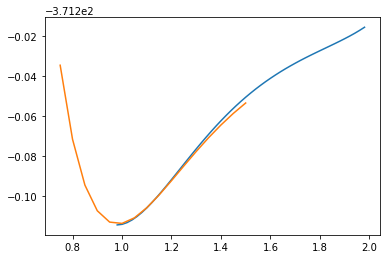

In [96]:
fig = plt.figure()
ax = plt.axes()

ax.plot(np.linspace(0.98055084, 1.98055084, 51), anne_ihoh_energy)
ax.plot(np.linspace(0.75, 1.50, 16), ihod.MP2Energy)

In [7]:
#equilibrium charge values:
clhocl_eq = np.array([-0.77004, 0.15020, -0.85006, 0.46989])
clhod_eq = np.array([-0.99517, 0.43622, -0.93278, 0.49173])
brhocl_eq = np.array([-0.76825, 0.15748, -0.85902, 0.46979])
brhod_eq = np.array([-0.98812, 0.43884, -0.93907, 0.48835])
ihocl_eq = np.array([-0.76432, 0.16510, -0.86952, 0.46873])
ihod_eq = np.array([-1.38119, 0.66437, -0.97350, 0.69032])

# Make q-q_eq plots

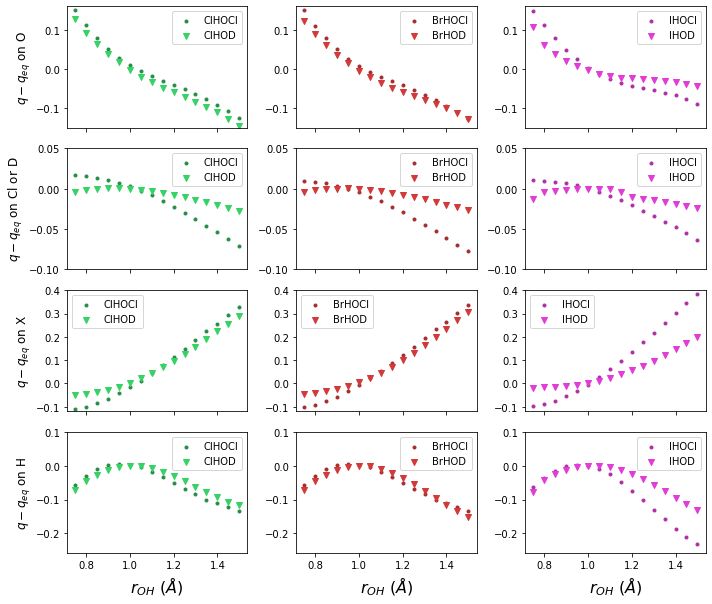

In [108]:
%matplotlib inline
fig, axs = plt.subplots(4, 3, sharex=True)


oop = np.arange(0.75,1.55,0.05)
axs[0,0].scatter(oop, clhocl_rOH_nbo[:,0]-clhocl_eq[0], label="ClHOCl", color='#268D45', marker='.')
axs[1,0].scatter(oop, clhocl_rOH_nbo[:,1]-clhocl_eq[1], label="ClHOCl", color='#268D45', marker='.')
axs[2,0].scatter(oop, clhocl_rOH_nbo[:,2]-clhocl_eq[2], label="ClHOCl", color='#268D45', marker='.')
axs[3,0].scatter(oop, clhocl_rOH_nbo[:,3]-clhocl_eq[3], label="ClHOCl", color='#268D45', marker='.')

axs[0,0].scatter(oop, clhod_rOH_nbo[:,0]-clhod_eq[0], label="ClHOD", color='#37D266', marker='v')
axs[1,0].scatter(oop, clhod_rOH_nbo[:,1]-clhod_eq[1], label="ClHOD", color='#37D266', marker='v')
axs[2,0].scatter(oop, clhod_rOH_nbo[:,2]-clhod_eq[2], label="ClHOD", color='#37D266', marker='v')
axs[3,0].scatter(oop, clhod_rOH_nbo[:,3]-clhod_eq[3], label="ClHOD", color='#37D266', marker='v')

axs[0,1].scatter(oop, brhocl_rOH_nbo[:,0]-brhocl_eq[0], label="BrHOCl", color='#A42D2D', marker='.')
axs[1,1].scatter(oop, brhocl_rOH_nbo[:,1]-brhocl_eq[1], label="BrHOCl", color='#A42D2D', marker='.')
axs[2,1].scatter(oop, brhocl_rOH_nbo[:,2]-brhocl_eq[2], label="BrHOCl", color='#A42D2D', marker='.')
axs[3,1].scatter(oop, brhocl_rOH_nbo[:,3]-brhocl_eq[3], label="BrHOCl", color='#A42D2D', marker='.')

axs[0,1].scatter(oop, brhod_rOH_nbo[:,0]-brhod_eq[0], label="BrHOD", color='#D23939', marker='v')
axs[1,1].scatter(oop, brhod_rOH_nbo[:,1]-brhod_eq[1], label="BrHOD", color='#D23939', marker='v')
axs[2,1].scatter(oop, brhod_rOH_nbo[:,2]-brhod_eq[2], label="BrHOD", color='#D23939', marker='v')
axs[3,1].scatter(oop, brhod_rOH_nbo[:,3]-brhod_eq[3], label="BrHOD", color='#D23939', marker='v')

axs[0,2].scatter(oop, ihocl_rOH_nbo[:,0]-ihocl_eq[0], label="IHOCl", color='#AE2FA5', marker='.')
axs[1,2].scatter(oop, ihocl_rOH_nbo[:,1]-ihocl_eq[1], label="IHOCl", color='#AE2FA5', marker='.')
axs[2,2].scatter(oop, ihocl_rOH_nbo[:,2]-ihocl_eq[2], label="IHOCl", color='#AE2FA5', marker='.')
axs[3,2].scatter(oop, ihocl_rOH_nbo[:,3]-ihocl_eq[3], label="IHOCl", color='#AE2FA5', marker='.')

axs[0,2].scatter(oop, ihod_rOH_nbo[:,0]-ihod_eq[0], label="IHOD", color='#E13CD6', marker='v')
axs[1,2].scatter(oop, ihod_rOH_nbo[:,1]-ihod_eq[1], label="IHOD", color='#E13CD6', marker='v')
axs[2,2].scatter(oop, ihod_rOH_nbo[:,2]-ihod_eq[2], label="IHOD", color='#E13CD6', marker='v')
axs[3,2].scatter(oop, ihod_rOH_nbo[:,3]-ihod_eq[3], label="IHOD", color='#E13CD6', marker='v')


for ax in axs[0,:]:
    ax.set_ylim(-.15, .16)
    
for ax in axs[1,:]:
    ax.set_ylim(-.1, 0.05)

for ax in axs[2,:]:
    ax.set_ylim(-.12, 0.4)

for ax in axs[3,:]:
    ax.set_ylim(-.26, 0.1)

for a in axs:
    for b in a:
        b.legend(loc='best')
        
#axs[0,0].set_title("NBO tz")
axs[0,0].set_ylabel("$q-q_{eq}$ on O", fontsize=12)
axs[1,0].set_ylabel("$q-q_{eq}$ on Cl or D", fontsize=12)
axs[2,0].set_ylabel("$q-q_{eq}$ on X", fontsize=12)
axs[3,0].set_ylabel("$q-q_{eq}$ on H", fontsize=12)

axs[3,0].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)
axs[3,1].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)
axs[3,2].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)


fig.subplots_adjust(wspace = 0, hspace = 0)
fig.set_size_inches(w=10,h=8.5)
        
plt.tight_layout()

plt.savefig('natural_charges_xhocl_v_xhod_q-qeq.pdf')


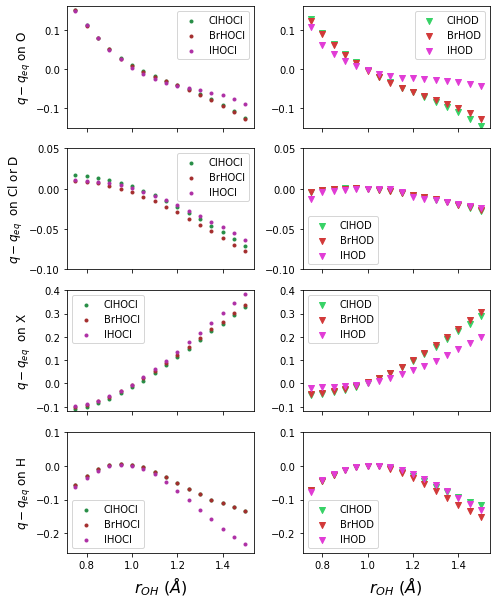

In [8]:
%matplotlib inline
fig, axs = plt.subplots(4, 2, sharex=True)


oop = np.arange(0.75,1.55,0.05)
for i in range(4): axs[i,0].scatter(oop, clhocl_rOH_nbo[:,i]-clhocl_eq[i], label="ClHOCl", color='#268D45', marker='.')
for i in range(4): axs[i,1].scatter(oop, clhod_rOH_nbo[:,i]-clhod_eq[i], label="ClHOD", color='#37D266', marker='v')
for i in range(4): axs[i,0].scatter(oop, brhocl_rOH_nbo[:,i]-brhocl_eq[i], label="BrHOCl", color='#A42D2D', marker='.')
for i in range(4): axs[i,1].scatter(oop, brhod_rOH_nbo[:,i]-brhod_eq[i], label="BrHOD", color='#D23939', marker='v')
for i in range(4): axs[i,0].scatter(oop, ihocl_rOH_nbo[:,i]-ihocl_eq[i], label="IHOCl", color='#AE2FA5', marker='.')
for i in range(4): axs[i,1].scatter(oop, ihod_rOH_nbo[:,i]-ihod_eq[i], label="IHOD", color='#E13CD6', marker='v')


for ax in axs[0,:]:
    ax.set_ylim(-.15, .16)
    
for ax in axs[1,:]:
    ax.set_ylim(-.1, 0.05)

for ax in axs[2,:]:
    ax.set_ylim(-.12, 0.4)

for ax in axs[3,:]:
    ax.set_ylim(-.26, 0.1)

for a in axs:
    for b in a:
        b.legend(loc='best')
        
#axs[0,0].set_title("NBO tz")
axs[0,0].set_ylabel("$q-q_{eq}$ on O", fontsize=12)
axs[1,0].set_ylabel("$q-q_{eq}$  on Cl or D", fontsize=12)
axs[2,0].set_ylabel("$q-q_{eq}$  on X", fontsize=12)
axs[3,0].set_ylabel("$q-q_{eq}$ on H", fontsize=12)

axs[3,0].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)
axs[3,1].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)


fig.subplots_adjust(wspace = 0, hspace = 0)
fig.set_size_inches(w=7,h=8.5)
        
plt.tight_layout()
plt.savefig('natural_charges_xhocl_v_xhod_version2_q-qeq.pdf')
